Name: Timolai Andrievich  
Group: BS21-DS01

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timolai-andrievich/stfds23-casestudy/blob/main/study.ipynb)

In [1]:
# Install dependencies
%pip install numpy pandas matplotlib seaborn tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Type hints
from typing import List

# Import the required libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import tqdm

In [3]:
# Seed all the pseudo-random data in the notebook
np.random.seed(42)

In [4]:
# Load data
cmv_data_df = pd.read_csv('hcmv.data.txt')
cmv_data = np.array(cmv_data_df['location'])

## Preliminary data exploration

From the paper, it is known that the total length of the DNA sequence is 229354.

In [5]:
cmv_sequence_length = 229354

In [6]:
len(cmv_data_df)

296

So, there are a total of 296 palindromes that fit requirements (length more than 10 bases). From this, we can calculate the mathematical expectation of the length of the spacing in the sequence: $$\mathbb{E}(\text{space}) = \frac{\text{total length of the sequence}}{\text{the number of palindromes}} =  \\ = \frac{229354}{296} \approx 774.84$$

## Random scatter

In [7]:
# Generate the mock data
pseudo_random_scatter_data = np.random.randint(0, cmv_sequence_length - 1, size=(10, 296))
# Sort in non-decreasing order
pseudo_random_scatter_data = np.sort(pseudo_random_scatter_data, axis=-1)

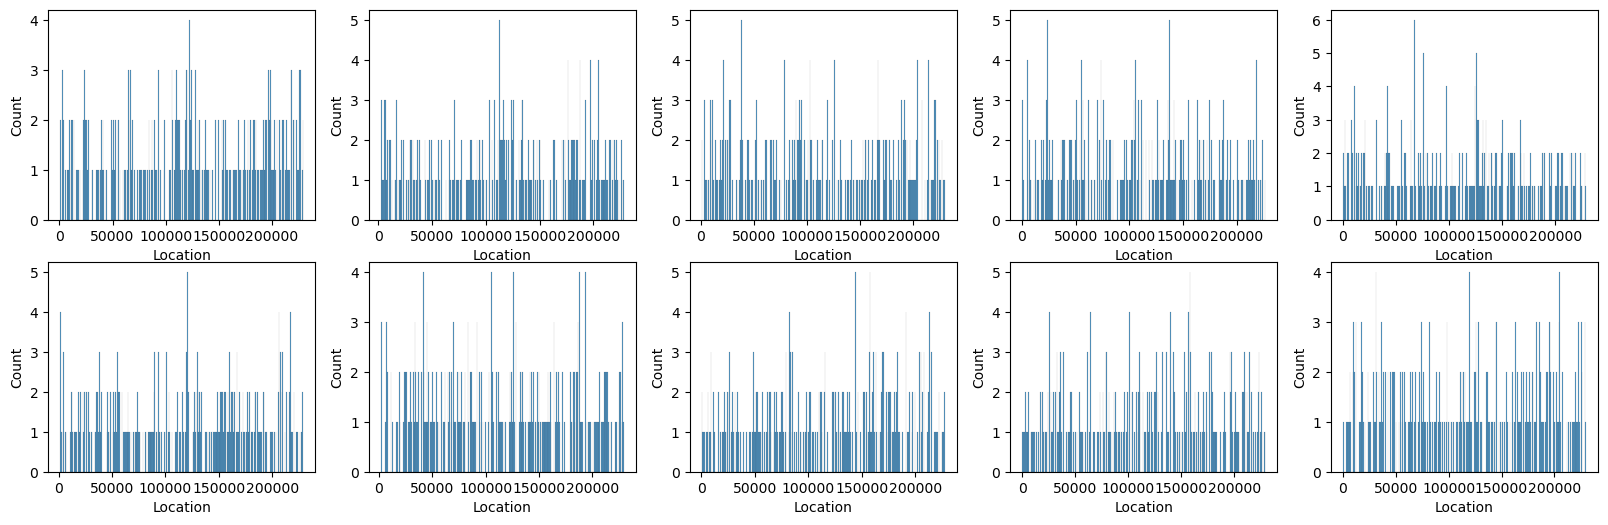

In [8]:
fig = plt.figure(figsize=(20, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    sns.histplot(x=pseudo_random_scatter_data[i], binwidth=700)
    plt.xlabel("Location")

As shown in the figure, in most of the bins, there are 0 or 1 palindromes, with maximum amount of palindromes in one bin being 7.  
Now to plot the real data.

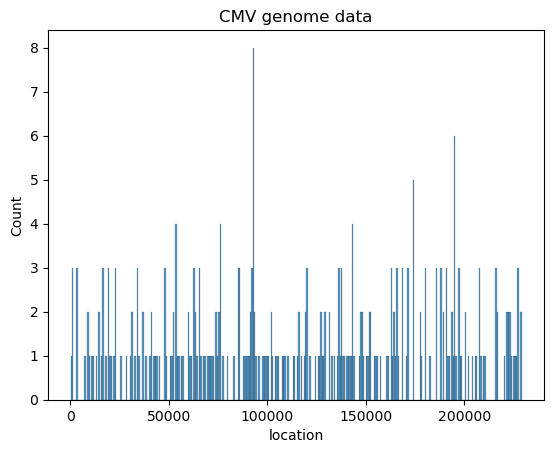

In [9]:
sns.histplot(data=cmv_data_df, x='location', binwidth=700)
plt.title('CMV genome data')
plt.show()

A very noticeable spike is located around 100000 bases away from the start of the sequence. Of course, nothing can be said without further statistical analysis, but it can be a good starting point for investigation.

## Locations and spacings

In [10]:
def calculate_spacings(data: np.ndarray) -> np.ndarray:
    """Calculates the spacings between the locations of the palindromes in the data.

Args:
    data (ndarray): One-dimensional numpy array containing the locations of the palindromes.
Must contain strictly more than 1 element.

Returns: 
    ndarray: The spacings between the palindromes. One element shorter than the `data` array"""
    assert len(data) > 1
    return data[1:] - data[:-1]

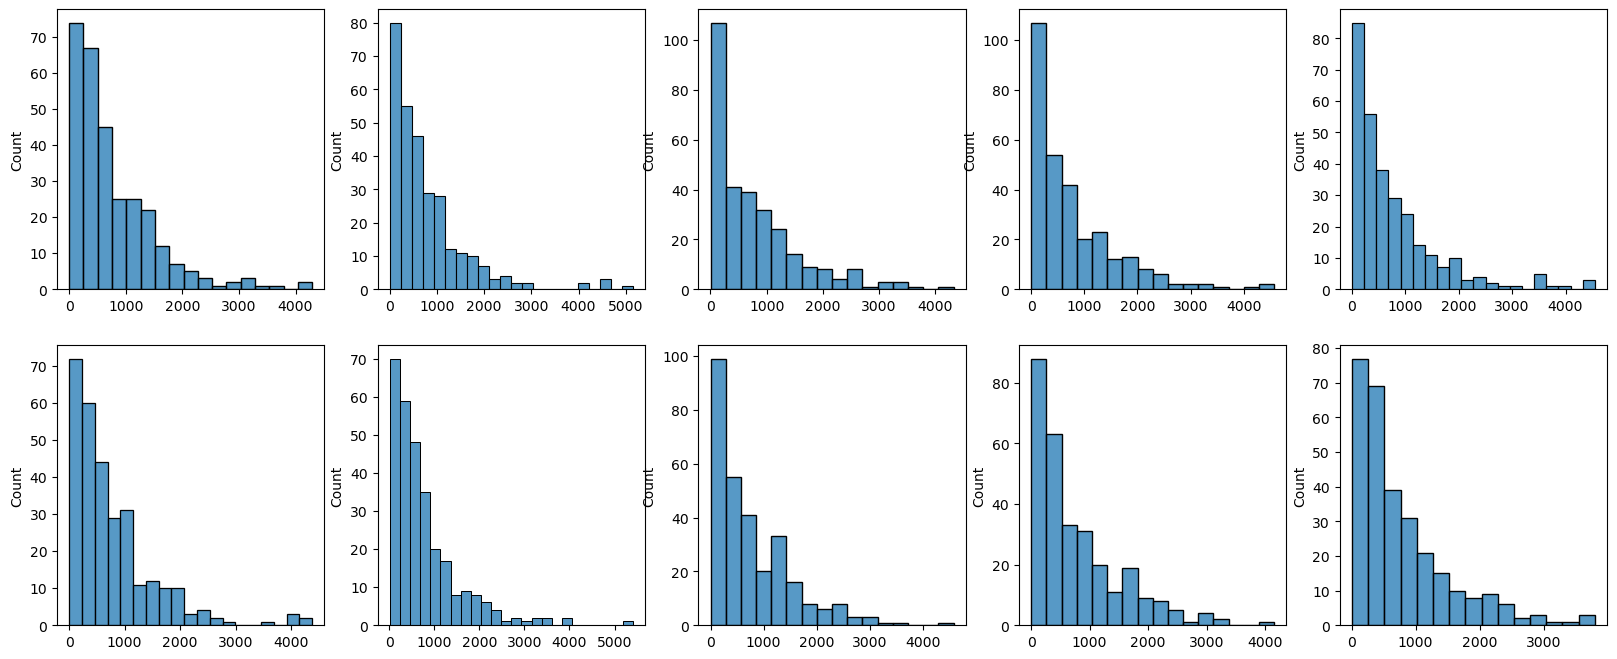

In [11]:
fig = plt.figure(figsize=(20, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    sns.histplot(x=calculate_spacings(pseudo_random_scatter_data[i]))

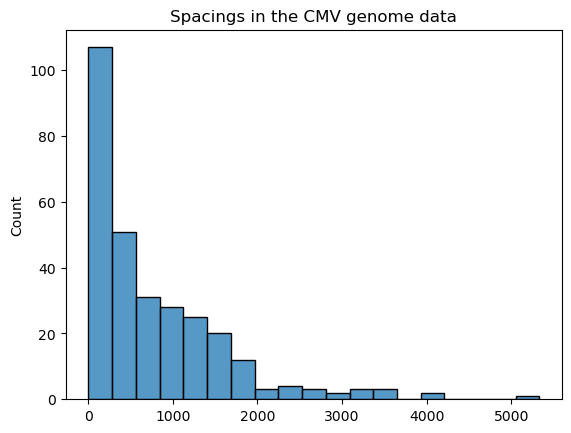

In [12]:
plt.title('Spacings in the CMV genome data')
sns.histplot(calculate_spacings(cmv_data))
plt.show()

The distributions of spacing lengths in CMV genome and pseudo-random uniform scatter seem to be quite similar. This suggests that uniform distribution is overall a good approximation of the palindrome locations.

## Counts

Now, to more formal statistical tests. Let the level of statistical significance $\alpha$ be equal to $.01$. It might be beneficial to split the DNA into bins and count the palindromes inside each one.
The mathematical expectation of the length of the space between palindromes (775) seems like a good first candidate for the length of the bin.
However, 229354 (the total length of the DNA sequence) is not divisible by 775. The decreased length of the last bin can interfere with
the data. As there was no anomalies detected in the end of the sequence during graphical analysis, the tailing bin can be simply
discarded, with the new length of sequence being 228624, which can be split into 295 bins containing 775 bases each.

In [13]:
def split_into_bins(data: np.ndarray, bins: int = 295, length: int = 775) -> List[List[int]]:
    """Splits the palindromes into `bins` bins, `length` bases long each. 
The palindromes that do not fit into any of the bins are discarded.

Args:
    data (ndarray): The numpy array containing the locations of the palindromes.
    bins (int, optional): The number of bins to split the data into. Defaults to 295.
    length (int, optional): The length of each bin. Defaults to 775.

Returns:
    List[List[int]]: The list of bins, each of which contains all palindromes that fit in it."""
    res = [[] for _ in range(bins)]
    for location in data:
        bin = location // length
        if not (0 <= bin < bins):
            # Discard the palindrome
            continue
        res[bin].append(location)
    return res


def count_palindromes_in_bins(data: np.ndarray, bins: int = 295, length: int = 775) -> np.ndarray:
    """Splits the data into `bins` bins and returns the amount of palindromes in each bin.
    Palindromes that do not fit into any bin are not counted.

    Args:
        data (np.ndarray): The numpy array with the locations of the palindromes.
        bins (int, optional): The number of bins to split the data into. Defaults to 295.
        length (int, optional): The length of each bin. Defaults to 775.

    Returns:
        List[int]: The list of the counts of the palindromes in the bins.
    """
    return np.array(list(map(len, split_into_bins(data, bins, length))))

In [14]:
def make_piechart(data: np.ndarray, bins: int = 295, length: int = 775):
    """Plots the data about the count of palindromes in each bin as a piechart.
    The size of the slices is in logarithmic scale. Note that the values on the
    slices may be inaccurate if `bins` * `length` is greater that approximately 10^6.

    Args:
        data (np.ndarray): The numpy array with the locations of the palindromes.
        bins (int, optional): The number of bins to split the data into. Defaults to 295.
        length (int, optional): The length of each bin. Defaults to 775.
    """
    labels, counts = np.unique(count_palindromes_in_bins(data, bins, length), return_counts=True)
    log_counts = np.log(counts + 1)
    explode = np.ones_like(counts) / 20
    colors = sns.color_palette('pastel')
    counts_sum = counts.sum()
    def autopct(pct):
        value = int(round(np.exp(pct * log_counts.sum() / 100) - 1))
        return f'{value} ({value / counts_sum * 100:.2f}%)'
    plt.pie(log_counts, labels=labels, explode=explode, colors=colors, autopct=autopct)

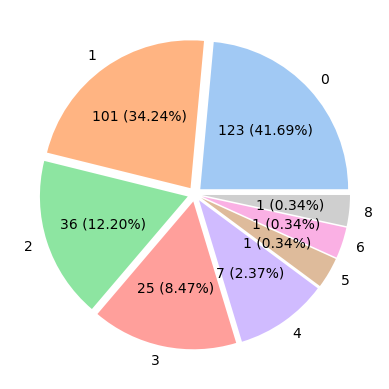

In [15]:
make_piechart(cmv_data)

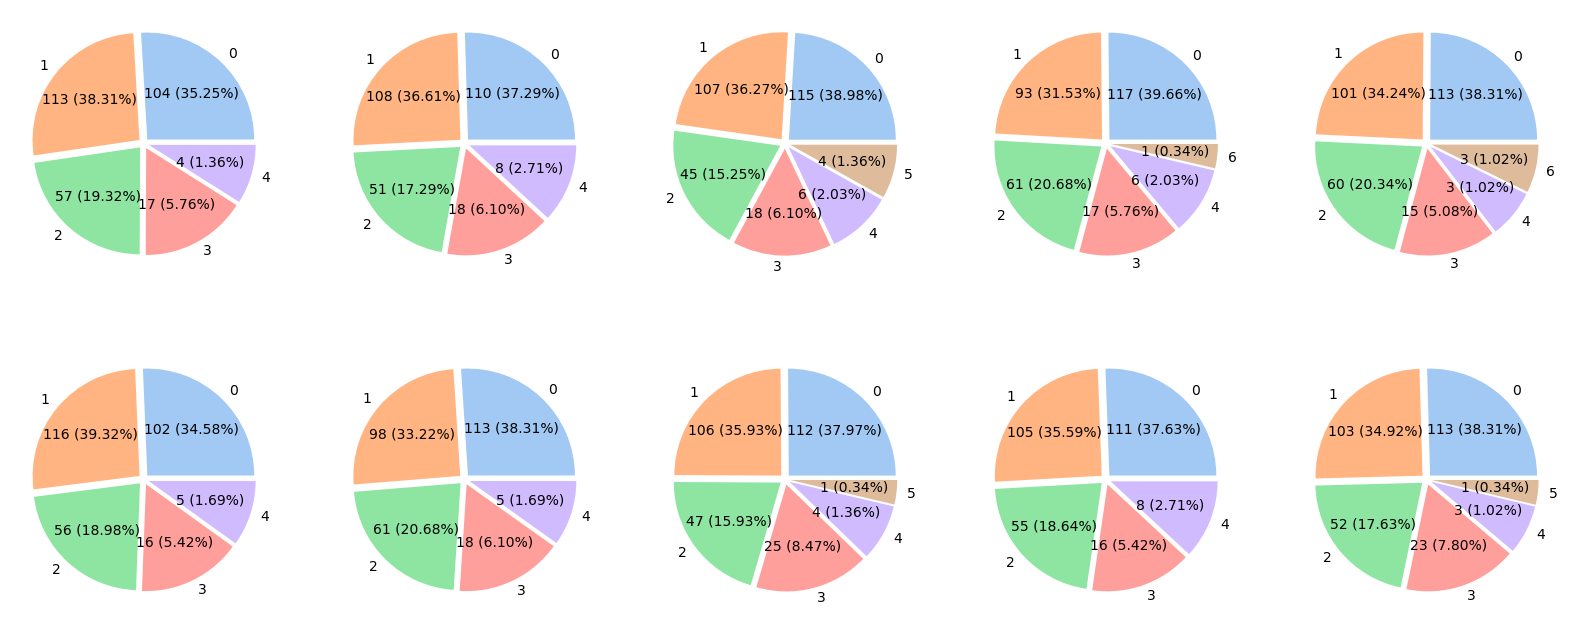

In [16]:
fig = plt.figure(figsize=(20, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    make_piechart(pseudo_random_scatter_data[i])

Because the distribution of palindromes is similar to uniform, the probability of $k$ palindromes occurring in the bin with width of $w$ can be approximated with Poisson distribution with $\lambda = \frac{w}{\mathbb{E}(\text{spacing})}$.

Therefore, the probability of $k$ palindromes occurring in one bin is approximately $$p(k, w) = \frac{\lambda^k e^{-\lambda}}{k!}, \lambda=\frac{w \cdot n}{L}$$
Where $n$ is the total amount of palindromes in the data, $L$ is the total length of the DNA sequence. And the probability of $k$ palindromes not occurring once in $b$ bins is:
$$P(k, w, b) = 1 - \left(1 - \frac{\lambda^k e^{-\lambda}}{k!}\right)^b, \lambda=\frac{w \cdot n}{L}$$
In other words, $P$ is the probability that there is at least one bin containing $k$ or more palindromes.

In [17]:
import math
def P(k, bin_width, bin_count):
    rate = bin_width * len(cmv_data) / cmv_sequence_length
    p = 1 - (rate ** k) * (math.e ** -rate) / math.factorial(k)
    return 1 - p ** bin_count

In [18]:
P(8, 775, 295)

0.0026917423569375876

Substituting the parameters used for performed experiments, the $p$-value is approximately $p = .003$ which is statistically significant according to level of significance $\alpha = .01$, set earlier.

### Simulation check

To test the correctness of derived formula, pseudo-random simulations can be used.

In [19]:
num_simulations = 100000
np.random.seed(42)

def generate_data():
    return np.sort(np.random.randint(0, cmv_sequence_length - 1, size=len(cmv_data)))

def maximum_cluster(data, bins = 295, bin_width = 775):
    return max(count_palindromes_in_bins(data, bins, bin_width))

simulation_results = []
for _ in tqdm.trange(num_simulations):
    simulation_results.append(maximum_cluster(generate_data()))

100%|██████████| 100000/100000 [00:24<00:00, 4011.63it/s]


In [20]:
labels, counts = np.unique(simulation_results, return_counts=True)
cs_counts = np.cumsum(counts[::-1])[::-1]

In [21]:
for label, count in zip(labels, cs_counts):
    print(f'{count:>8} ({count / num_simulations * 100:05.2f}%) simulations produced data where at least one bin had {label} palindromes.')

  100000 (100.00%) simulations produced data where at least one bin had 3 palindromes.
   99800 (99.80%) simulations produced data where at least one bin had 4 palindromes.
   66674 (66.67%) simulations produced data where at least one bin had 5 palindromes.
   15723 (15.72%) simulations produced data where at least one bin had 6 palindromes.
    2356 (02.36%) simulations produced data where at least one bin had 7 palindromes.
     257 (00.26%) simulations produced data where at least one bin had 8 palindromes.
      26 (00.03%) simulations produced data where at least one bin had 9 palindromes.


In [22]:
successes = cs_counts[labels.tolist().index(8)]
mean = P(8, 775, 295) * num_simulations
std = P(8, 775, 295) * (1 - P(8, 775, 295)) * num_simulations
print(f'The z-value is {(successes - mean) / std}')

The z-value is -0.045350157731088366


In simulations 257 out of 100000 randomly generated sequences produced bins with 8 palindromes in them. The probability of it happening given the probability $p = .0026917$, calculated earlier can be determined using the normal approximation to the binomial distribution. In this case, $\mu = pn$, and $\sigma = pqn$. The z-value $z=-0.045$ does not reach the critical value $2.58$ needed for the level of significance $\alpha = .01$, therefore the test failed to reject the hyphothesis that $p = .0026917$, given uniform distribution of palindromes.

## Conclusion



In [23]:
bins, bin_length = 295, 775
counts = count_palindromes_in_bins(cmv_data)
print(f'The cluster of 8 palindromes occurs in {counts.tolist().index(8) + 1}-th bin, which corresponds to the bases from {counts.tolist().index(8) * bin_length} to {counts.tolist().index(8) * bin_length + bin_length}')

The cluster of 8 palindromes occurs in 120-th bin, which corresponds to the bases from 92225 to 93000


A statistically significant cluster of palindromes occurs from 92225-th base to 93000-th base. One of the possible explanations of this cluster is that it is close to or contains the origin of replication. In case experiments prove otherwise, additional statistical analysis will be required, perhaps clustering using different sizes of bins.